## Foundations of Data Science Final Project

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [106]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(5)

In [107]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

### Dataset Preview

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/SamLv0114/Tandon-Bootcamp/main/age_std_suicide_rates_1990-2022.csv")
print(f"Total number of countries: {data['CountryName'].nunique()}")
data.head()

Total number of countries: 117


,RegionCode,RegionName,CountryCode,CountryName,Year,Sex,SuicideCount,CauseSpecificDeathPercentage,StdDeathRate,DeathRatePer100K,Population,GDP,GDPPerCapita,GNI,GNIPerCapita,InflationRate,EmploymentPopulationRatio
0,EU,Europe,ALB,Albania,1992,Male,33,0.331959,2.335802,2.076386,3247039.0,6.521750e+08,200.852220,9.061842e+08,1740.0,226.005421,45.315
1,EU,Europe,ALB,Albania,1992,Female,14,0.191860,0.866420,0.874563,3247039.0,6.521750e+08,200.852220,9.061842e+08,1740.0,226.005421,45.315
2,EU,Europe,ALB,Albania,1993,Male,46,0.477724,3.330938,2.937233,3227287.0,1.185315e+09,367.279225,1.024263e+09,2110.0,85.004751,47.798
3,EU,Europe,ALB,Albania,1993,Female,27,0.385164,1.755077,1.686025,3227287.0,1.185315e+09,367.279225,1.024263e+09,2110.0,85.004751,47.798
4,EU,Europe,ALB,Albania,1994,Male,37,0.419406,2.678796,2.332619,3207536.0,1.880951e+09,586.416135,1.216681e+09,2300.0,22.565053,50.086


The dataset includes the suicide count by country categorized by gender and corresponding Gross Domestic Product (GDP) per capita, Gross National Income (GNI) per capita, and employment rate of each country from 1990 to 2022.   
Source:
https://www.kaggle.com/datasets/ronaldonyango/global-suicide-rates-1990-to-2022/data

### Estimand

How does Employment Rate directly influence suicide rate and how does the influence associated with Gender?


### Causal Model

SR: SuicideRatePer100k\
ER: EmploymentPopulationRatio\
GDP: GDPPerCapita(Gross Domestic Product)\
GNI: GNIPerCapita(Gross National Income)\
G: Sex

![](DAG.png)

GDP -> GNI: An increase in GDP can attract foreign investment, leading to higher income levels within the country. This can affect GNI positively, especially if the investments are in sectors that contribute significantly to the economy and where profits are repatriated to domestic residents.  
GDP -> ER: An increase in GDP indicates a more active economy. More economic activity attracts more investment and product demand. This can cause a higher demand for labor.  
ER -> GNI: A higher employment rate may bring more people to work, thus increasing individual income.   
In reality, gender should affect the employment rate. However, in this dataset, the causal relation is not clear and we will verify it during the model-building process.



#### Data Processing

In [110]:
data = data.dropna()

In [109]:
data = data.drop(["RegionCode","RegionName","CountryCode","CauseSpecificDeathPercentage","StdDeathRate","DeathRatePer100K","GDP","GNI","InflationRate"], axis=1)

In [111]:
data['SuicideRatePer100k'] = data['SuicideCount'] / data['Population'] * 100000

In [112]:
data.describe()

,Year,SuicideCount,Population,GDPPerCapita,GNIPerCapita,EmploymentPopulationRatio,SuicideRatePer100k
count,5128.000000,5128.000000,5.128000e+03,5128.000000,5128.000000,5128.000000,5128.000000
mean,2006.424532,1401.733619,2.651921e+07,18095.158021,22532.472699,55.863962,5.174138
std,8.385936,4110.741794,4.699040e+07,19899.995039,19223.445253,8.130905,5.533146
min,1991.000000,0.000000,1.043320e+05,137.181909,780.000000,32.026000,0.000000
25%,2000.000000,46.000000,3.048162e+06,3885.935344,8627.500000,50.958750,1.370255
50%,2007.000000,275.000000,7.385602e+06,10064.757665,16540.000000,56.306000,3.420487
75%,2013.000000,916.250000,3.045258e+07,26666.079182,30650.000000,60.557000,7.006503
max,2022.000000,51464.000000,3.320316e+08,133711.794400,152630.000000,87.518000,38.566054


In [113]:
data.head()

,CountryName,Year,Sex,SuicideCount,Population,GDPPerCapita,GNIPerCapita,EmploymentPopulationRatio,SuicideRatePer100k
0,Albania,1992,Male,33,3247039.0,200.852220,1740.0,45.315,1.016311
1,Albania,1992,Female,14,3247039.0,200.852220,1740.0,45.315,0.431162
2,Albania,1993,Male,46,3227287.0,367.279225,2110.0,47.798,1.425346
3,Albania,1993,Female,27,3227287.0,367.279225,2110.0,47.798,0.836616
4,Albania,1994,Male,37,3207536.0,586.416135,2300.0,50.086,1.153533


In [114]:
GDP = data.GDPPerCapita
ER = data.EmploymentPopulationRatio
GNI = data.GNIPerCapita
GDP_std = standardize(GDP)
ER_std = standardize(ER)
GNI_std = standardize(GNI)
G = np.where(data.Sex == 'Female', 1, 0)
SR = data['SuicideRatePer100k']

#### Data Visualization

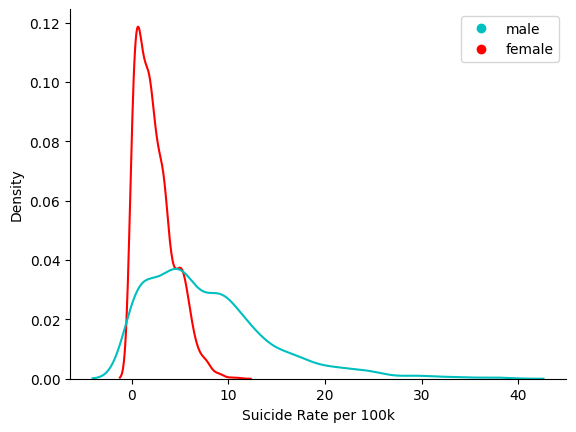

In [115]:
_ = sns.kdeplot(data=data, x=SR, hue=G, palette=['c', 'r'])
custom = [Line2D([], [], marker='o', color='c', linestyle='None'),
          Line2D([], [], marker='o', color='r', linestyle='None')]

_ = plt.xlabel("Suicide Rate per 100k")
_ = plt.legend(custom, ['male', 'female'], loc='upper right')
_ = sns.despine()

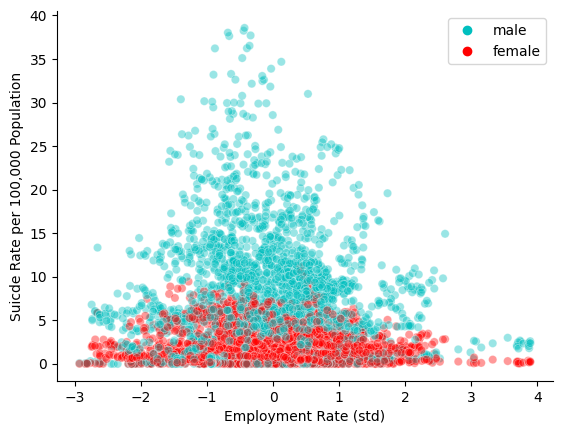

In [116]:
_ = sns.scatterplot(data=data, x=ER_std, y=SR, hue=G, palette=['c', 'r'], alpha=0.4)

custom = [Line2D([], [], marker='o', color='c', linestyle='None'),
          Line2D([], [], marker='o', color='r', linestyle='None')]

_ = plt.xlabel("Employment Rate (std)")
_ = plt.ylabel("Suicde Rate per 100,000 Population")
_ = plt.legend(custom, ['male', 'female'], loc='upper right')
_ = sns.despine()

### Statistical Model

To estimate the direct effect of Employment Rate on the Suicide Rate associated with Gender, we need to stratify on GNI and GDP per capita.

GDP is a confounder. It forms a fork: ER<-GDP->SR. Based on the backdoor criteria, we need to stratify on GDP to close the causal path.

GNI is a mediator. ER->GNI->SR. So we also need to stratify on GNI.

$SR_i \sim \text{LogNormal}(\mu_i, \sigma)$  
$\mu_i = \alpha_{G[i]} + \beta_{ER, G[i]} ER[i]  + \beta_{GNI, G[i]} GNI[i] + \beta_{GDP, G[i]} GDP[i]$

To ensure that the Suicide Rate is positive, we decided to use LogNormal distribution for the model.

#### Prior Predictive Simulation

According to data from World Bank, the worldwide suicide motality rate per 100,000 population in 2009 is 11. The suicide motality rate for [female](https://data.worldbank.org/indicator/SH.STA.SUIC.P5) is 7 and the one for [male](https://data.worldbank.org/indicator/SH.STA.SUIC.MA.P5) is 14.8.  

For sex of the population, we set Male as G = 0 and Female as G = 1

We can set the prior for now as  
$\alpha_0 \sim \text{Normal}(\text{ln}(14.8), 1)$  
$\alpha_1 \sim \text{Normal}(\text{ln}(7), 1)$  
$\beta_j \sim \text{Normal}(0,1)$  
$\sigma \sim \text{Exponential}(1)$

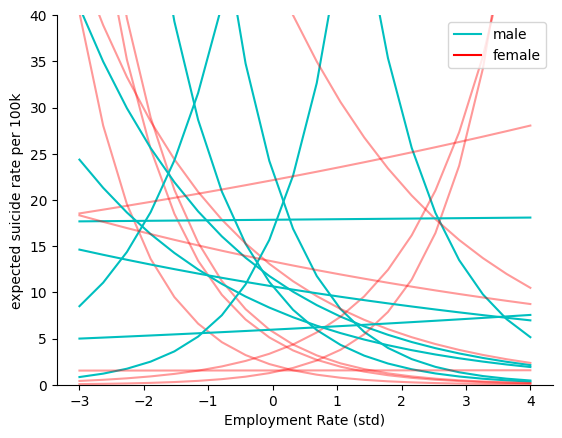

In [117]:
NUM_LINES = 10
x_seq = np.linspace(-3, 4, 20)

a0 = stats.norm.rvs(np.log(14.8), 1, size=NUM_LINES)
a1 = stats.norm.rvs(np.log(7), 1, size=NUM_LINES)
b = stats.norm.rvs(0, 1, size=NUM_LINES)

for i in range(NUM_LINES):
  mu0 = np.exp(a0[i] + b[i] * x_seq)
  _ = plt.plot(x_seq, mu0, color='c')

  mu1 = np.exp(a1[i] + b[i] * x_seq)
  _ = plt.plot(x_seq, mu1, color='r', alpha=0.4)

custom = [Line2D([], [], color='c', linestyle='-'),
          Line2D([], [], color='r', linestyle='-')]

plt.ylim((0, 40))
plt.ylabel("expected suicide rate per 100k")
plt.xlabel("Employment Rate (std)")
plt.xticks(np.arange(-3, 5, step=1))
_ = plt.legend(custom, ['male', 'female'], loc='upper right')
sns.despine()

We can see that change in standardized employment rate leads to a dramatic change in expected suicide rate per 100k. We need to have a tighter prior in this case.

We can set the prior for now as  
$\alpha_0 \sim \text{Normal}(\text{ln}(14.8), 0.5)$  
$\alpha_1 \sim \text{Normal}(\text{ln}(7), 0.5)$  
$\beta_j \sim \text{Normal}(0,0.05)$  
$\sigma \sim \text{Exponential}(1)$

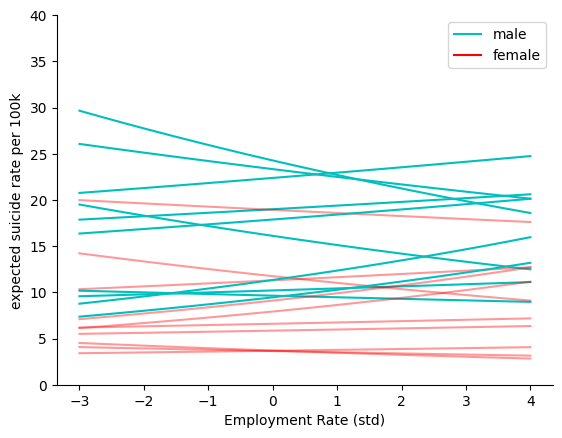

In [139]:
a0 = stats.norm.rvs(np.log(14.8), 0.5, size=NUM_LINES)
a1 = stats.norm.rvs(np.log(7), 0.5, size=NUM_LINES)
b = stats.norm.rvs(0, 0.05, size=NUM_LINES)

for i in range(NUM_LINES):
  mu0 = np.exp(a0[i] + b[i] * x_seq)
  _ = plt.plot(x_seq, mu0, color='c')

  mu1 = np.exp(a1[i] + b[i] * x_seq)
  _ = plt.plot(x_seq, mu1, color='r', alpha=0.4)

custom = [Line2D([], [], color='c', linestyle='-'),
          Line2D([], [], color='r', linestyle='-')]

plt.ylim((0, 40))
plt.ylabel("expected suicide rate per 100k")
plt.xlabel("Employment Rate (std)")
plt.xticks(np.arange(-3, 5, step=1))
_ = plt.legend(custom, ['male', 'female'], loc='upper right')
sns.despine()

Now in the simulation, the change of standardized Employment Rate leads to moderate change in expected suicide rate per 100k. This looks reasonable.

### Posterior Model

#### Computation of the Model

The model below is intended to measure the direct effect of the Employment Rate (ER) on the Suicide Rate (SR). The model is formulated as follows:

a, b, c, and d are coefficients for the intercepts and slopes respectively for GNI, GDP, and ER. Since we stratify on standardized GDP and GNI, Mu is the linear predictor based on the stratification. This model is built from a log-normally distributed variable around mu, with sigma controlling the spread of the distribution.

The structure of the model allows for the estimation of the direct effect of the Employment Rate on the Suicide Rate, as d[G] * ER_std captures the contribution of ER independently of the other variables in the model (GNI_std and GDP_std).

In [119]:
#add a small value to SR = 0 to fit the LogNormal model
SR = np.maximum(SR, 0.00000001)

In [141]:
with pm.Model() as m_sr:
  # Coefficients for the intercept and slopes for GNI, GDP, and ER
  a = pm.Normal("alpha", [np.log(14.8), np.log(7)], 0.5, shape=2)
  b = pm.Normal("beta_GNI", 0, 0.05, shape=2)
  c = pm.Normal("beta_GDP", 0, 0.05, shape=2)
  d = pm.Normal("beta_ER", 0, 0.05, shape=2)
  sigma = pm.Exponential("sigma", 1)

  # Linear predictor to measure the direct effect of ER on SR
  mu = a[G] + b[G]*GNI_std + c[G]*GDP_std + d[G]*ER_std

  # Use logNormal Distribution from PyMc
  SR_obs = pm.LogNormal("Suicide Rate", mu=mu, sigma=sigma, observed=SR)

  idata_m_sr = pm.sample(chains=4)

az.summary(idata_m_sr)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.258,0.064,1.157,1.360,0.001,0.001,5082.0,3279.0,1.0
alpha[1],-0.266,0.066,-0.368,-0.161,0.001,0.001,5570.0,2857.0,1.0
beta_GNI[0],0.046,0.042,-0.018,0.114,0.001,0.001,4355.0,3325.0,1.0
beta_GNI[1],0.027,0.042,-0.038,0.096,0.001,0.001,5010.0,3350.0,1.0
beta_GDP[0],0.134,0.042,0.065,0.202,0.001,0.000,4820.0,3130.0,1.0
beta_GDP[1],0.174,0.042,0.112,0.245,0.001,0.000,5010.0,3580.0,1.0
beta_ER[0],-0.030,0.040,-0.089,0.036,0.001,0.000,4791.0,3168.0,1.0
beta_ER[1],-0.081,0.039,-0.143,-0.020,0.001,0.000,5363.0,3154.0,1.0
sigma,3.351,0.033,3.301,3.407,0.000,0.000,4475.0,3114.0,1.0


#### Diagnostics for Posterior Samples

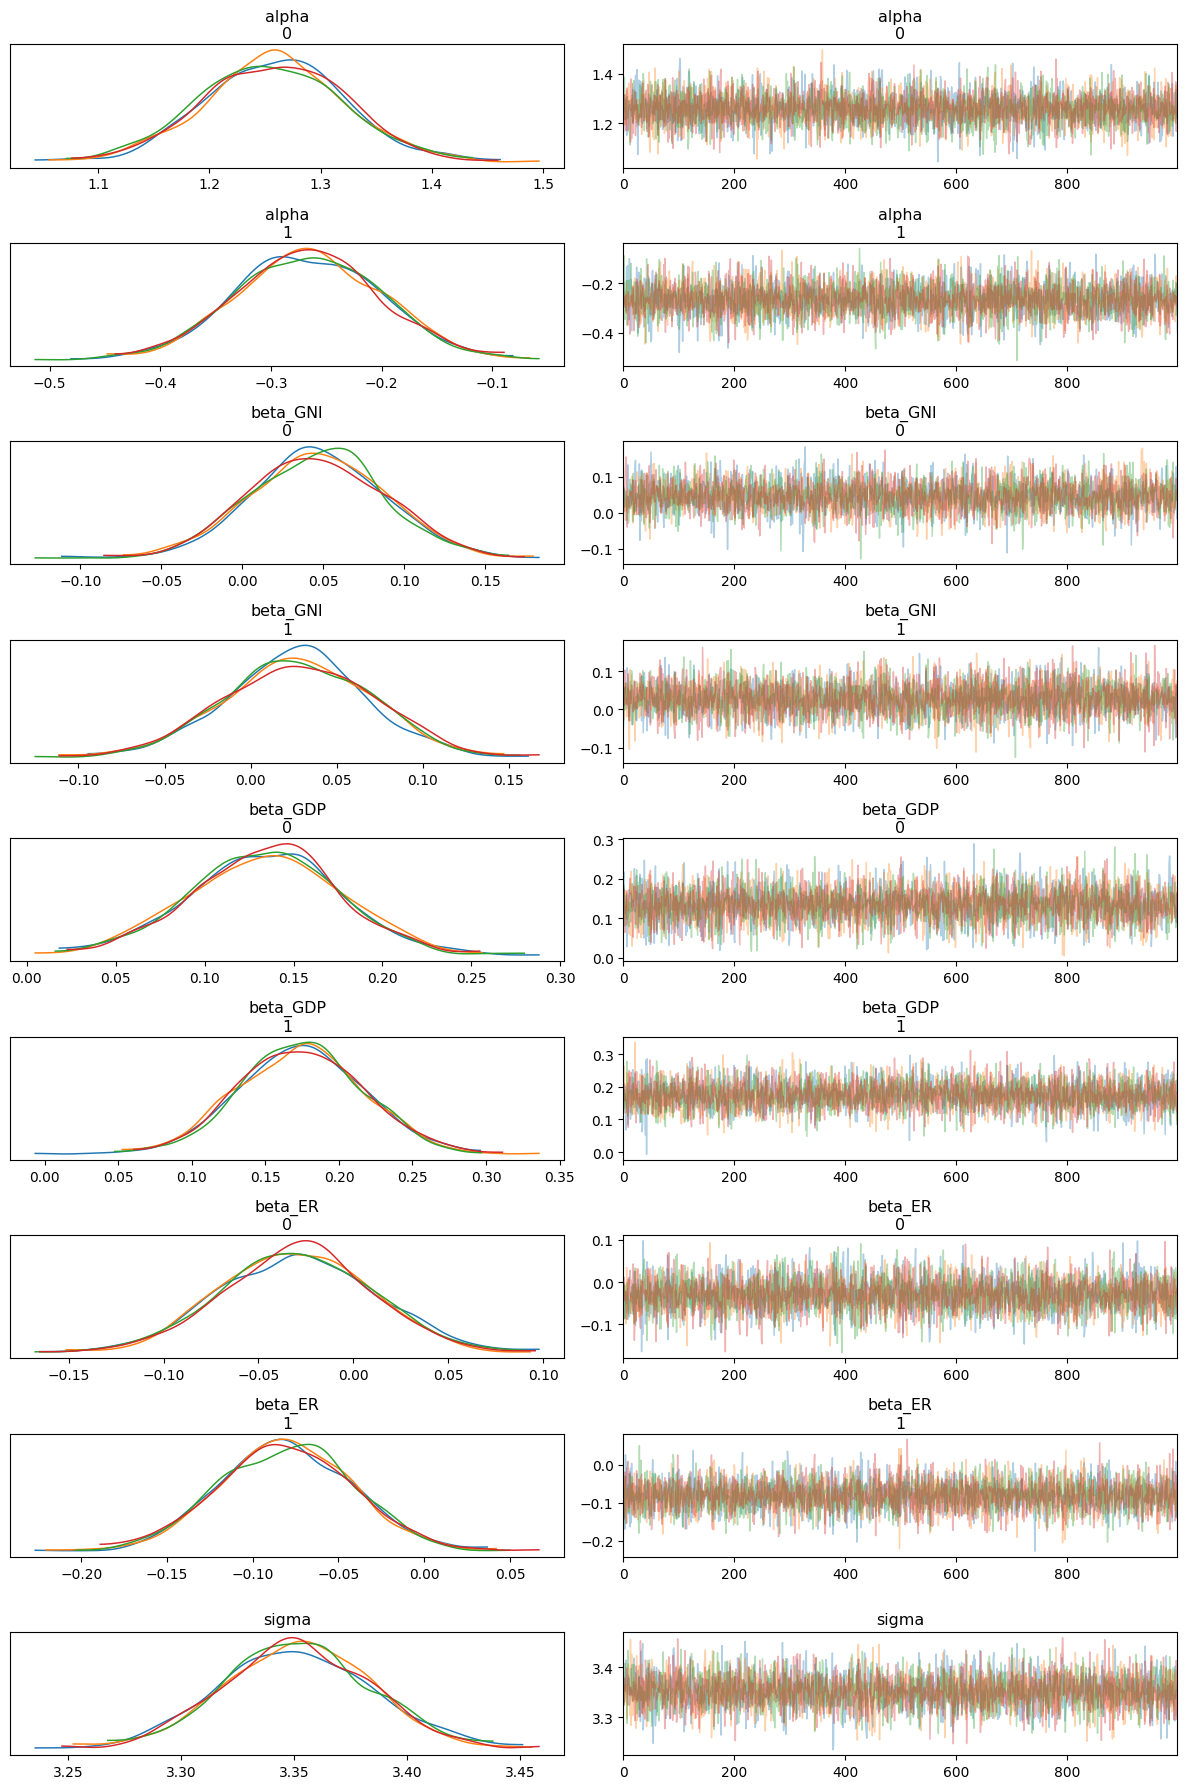

In [142]:
_ = az.plot_trace(idata_m_sr, compact=False)
plt.tight_layout()

Trace plots for each parameter show the desired stationarity, good mixing and convergence. This shows the sampling works with no issues.

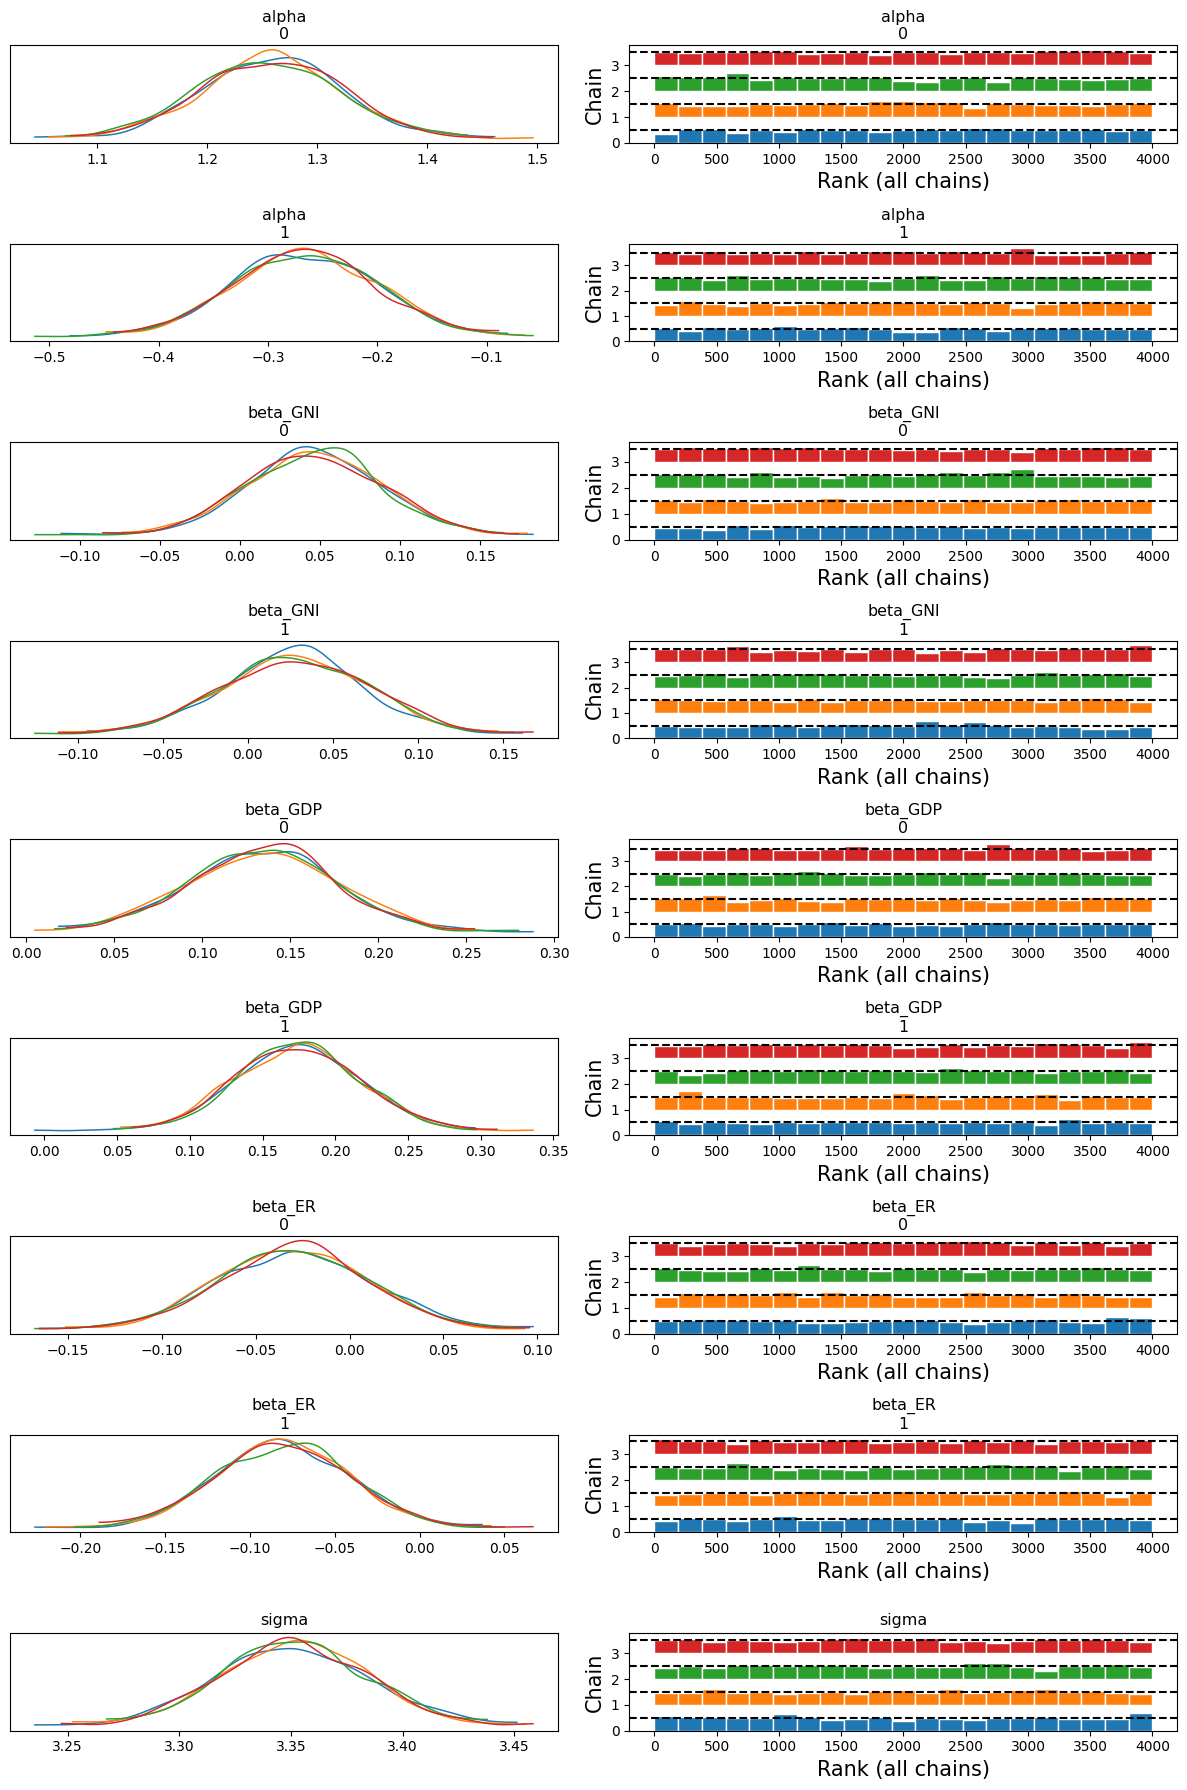

In [143]:
_ = az.plot_trace(idata_m_sr, kind="rank_bars", compact=False)
plt.tight_layout()

The trace rank plots show relatively uniform distribution amongst bars for all the parameters. This also show the sampling works with no issues.

R_hat value for all the parameters are 1. ess_bulk is also more than 400 for each parameters. These two supports that the sampling works with no problem.

### Posterior Predictive Checks

In [147]:
GNI_std_male = GNI_std[G == 0]
GNI_std_female = GNI_std[G == 1]
GDP_std_male = GDP_std[G == 0]
GDP_std_female = GDP_std[G == 1]
ER_std_male = ER_std[G == 0]
ER_std_female = ER_std[G == 1]

In [148]:
idata_m_sr_samples = az.extract(idata_m_sr, num_samples=1000)

a_values = idata_m_sr_samples.alpha.values
b_values = idata_m_sr_samples.beta_GNI.values
c_values = idata_m_sr_samples.beta_GDP.values
d_values = idata_m_sr_samples.beta_ER.values
sigma_values = idata_m_sr_samples.sigma.values

In [149]:
mu_pred_male_obs = np.zeros((len(ER_std_male), idata_m_sr_samples.sizes["sample"]))
mu_pred_female_obs = np.zeros((len(ER_std_female), idata_m_sr_samples.sizes["sample"]))
sr_pred_male = np.zeros((len(ER_std_male), idata_m_sr_samples.sizes["sample"]))
sr_pred_female = np.zeros((len(ER_std_female), idata_m_sr_samples.sizes["sample"]))

#### Checks for Male Data

<ipython-input-150-69e0fea88b19>:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis_mu_pred_male = az.hdi(mu_pred_male_obs.T)
<ipython-input-150-69e0fea88b19>:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis_sr_pred_male = az.hdi(sr_pred_male.T)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


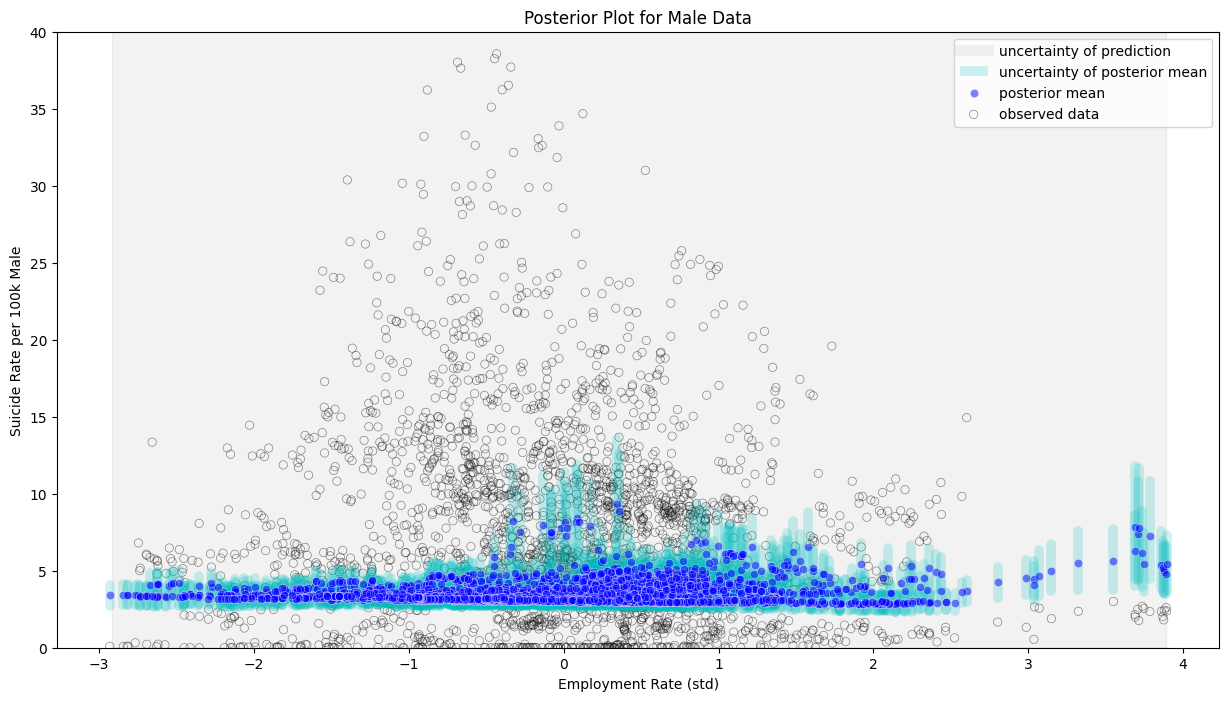

In [150]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Posterior Plot for Male Data")
for i, (GNI_male, GDP_male, ER_male) in enumerate(zip(GNI_std_male, GDP_std_male, ER_std_male)):
  mu_pred_male_obs[i] = a_values[0] + b_values[0] * GNI_male + c_values[0] * GDP_male + d_values[0] * ER_male
  sr_pred_male[i] = stats.lognorm.rvs(s=sigma_values, loc=0, scale=np.exp(mu_pred_male_obs[i]))

hdis_mu_pred_male = az.hdi(mu_pred_male_obs.T)
hdis_sr_pred_male = az.hdi(sr_pred_male.T)

#plot the uncertainty of posterior mean
ax.vlines(
    ER_std_male,
    np.exp(hdis_mu_pred_male[:,0]),
    np.exp(hdis_mu_pred_male[:,1]),
    color="c",
    lw=7,
    alpha=0.2,
    capstyle="round",
    label="uncertainty of posterior mean"
)

#plot the posterior mean
ax = sns.scatterplot(x=ER_std_male, y=np.exp(mu_pred_male_obs).mean(1), color='b', zorder=5, alpha = 0.5, label="posterior mean")

#plot the observed data
ax = sns.scatterplot(x=ER_std_male, y=SR[G == 0], color='None', edgecolor='k', alpha=0.5, label="observed data")

#plot the uncertainty of the prediction
ax = az.plot_hdi(ER_std_male, sr_pred_male.T, color='gray', fill_kwargs={"alpha": 0.1})

custom_line = [Line2D([0], [0], color='gray', alpha=0.1, linewidth=8)]
custom_label = ["uncertainty of prediction"]

_ = plt.ylim(0,40)
_ = plt.xlabel("Employment Rate (std)")
_ = plt.ylabel("Suicide Rate per 100k Male")
_ = plt.legend(custom_line + ax.get_legend_handles_labels()[0], custom_label + ax.get_legend_handles_labels()[1])

#### Checks for Female Data

<ipython-input-151-3cad51517437>:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis_mu_pred_female = az.hdi(mu_pred_female_obs.T)
<ipython-input-151-3cad51517437>:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis_sr_pred_female = az.hdi(sr_pred_female.T)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


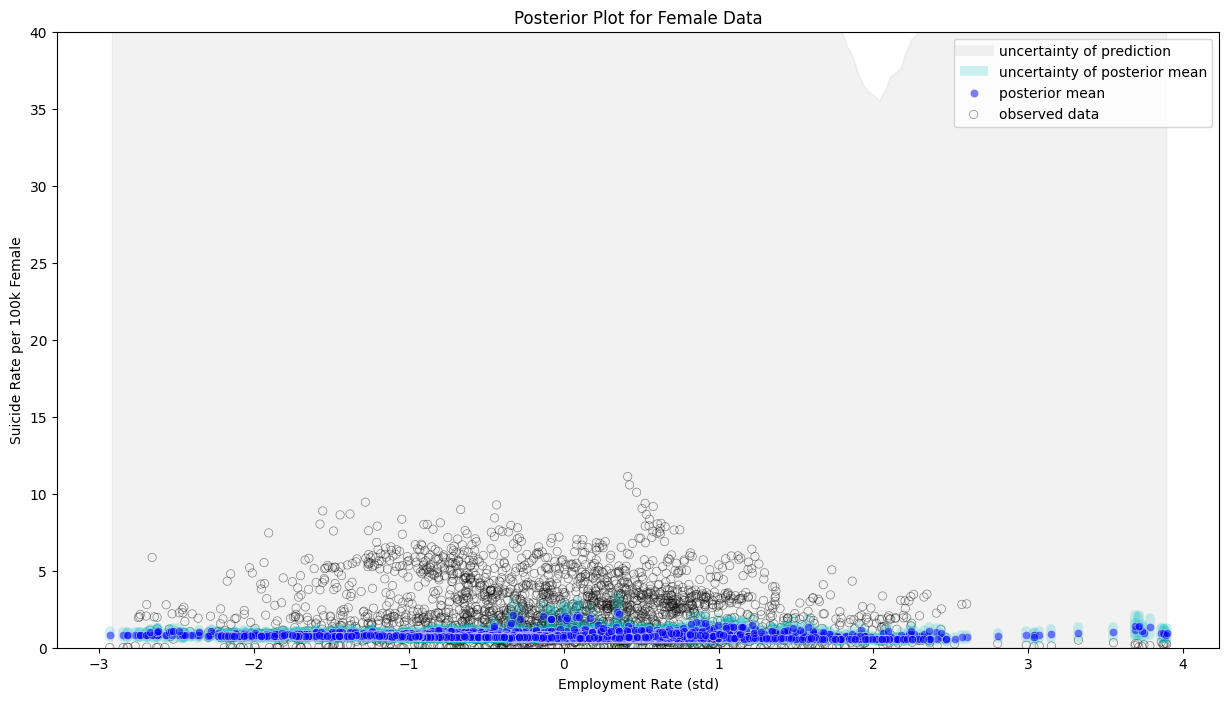

In [151]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Posterior Plot for Female Data")
for i, (GNI_female, GDP_female, ER_female) in enumerate(zip(GNI_std_female, GDP_std_female, ER_std_female)):
  mu_pred_female_obs[i] = a_values[1] + b_values[1] * GNI_female + c_values[1] * GDP_female + d_values[1] * ER_female
  sr_pred_female[i] = stats.lognorm.rvs(s=sigma_values, loc=0, scale=np.exp(mu_pred_female_obs[i]))

hdis_mu_pred_female = az.hdi(mu_pred_female_obs.T)
hdis_sr_pred_female = az.hdi(sr_pred_female.T)

#plot the uncertainty of posterior mean
ax.vlines(
    ER_std_female,
    np.exp(hdis_mu_pred_female[:,0]),
    np.exp(hdis_mu_pred_female[:,1]),
    color="c",
    lw=7,
    alpha=0.2,
    capstyle="round",
    label="uncertainty of posterior mean"
)

#plot the posterior mean
ax = sns.scatterplot(x=ER_std_female, y=np.exp(mu_pred_female_obs).mean(1), color='b', zorder=5, alpha = 0.5, label="posterior mean")

#plot the observed data
ax = sns.scatterplot(x=ER_std_female, y=SR[G == 1], color='None', edgecolor='k', alpha=0.5, label="observed data")

#plot the uncertainty of the prediction
ax = az.plot_hdi(ER_std_female, sr_pred_female.T, color='gray', fill_kwargs={"alpha": 0.1})

custom_line = [Line2D([0], [0], color='gray', alpha=0.1, linewidth=8)]
custom_label = ["uncertainty of prediction"]

_ = plt.ylim(0,40)
_ = plt.xlabel("Employment Rate (std)")
_ = plt.ylabel("Suicide Rate per 100k Female")
_ = plt.legend(custom_line + ax.get_legend_handles_labels()[0], custom_label + ax.get_legend_handles_labels()[1])

### Analysis:
**1. Visual Analysis of Fit:**
- The blue dots (posterior mean) and the surrounding shaded areas (uncertainty of posterior mean) provide a visual representation of where the model predicts the expected suicide rates based on the standardized employment rate.
- The observed data points (white circles) indicate the actual recorded values.
- The grey region represents the uncertainity of the prediction.

**2. Fit Across Different Employment Rates:**
- Male Data: The model also follows the central trend for the male data, but there are noticeable gaps between the observed data and the posterior mean at the higher values of suicide rates.
- Female Data: The model's posterior mean (blue dots) appears to capture the central trend of the observed data (white circles) fairly well across the range of employment rates. The uncertainty of the posterior mean (shaded blue area) is narrow, suggesting confidence in the model's predictions on the means where data is denser.
- However, the model's uncertainty for prediction is too big for the observed data. This shows that the model is very unconfident about the prediction. And the model might make predictions of suicide rate per 100K population that is too big compared to the reality. This indicates that while the model predicts the average trend correctly, the variance/sigma value is too large across the entire dataset. These might represent special cases or additional variables influencing suicide rates that are not captured in the current model.

**3. Gender Differences:**
- The spread of observed suicide rates is broader for males, especially when the standardized ER is around 0, but the model does not capture effectively. For females, while the model aligns well with many data points, it also fails to account for the upper range of suicide rates seen in the outliers.

**4. Model Uncertainity:**
- The shaded areas representing the uncertainty of the posterior mean are relatively narrow in some regions in the central range but become wider as moving toward the extremes of the employment rate. This increased uncertainty suggests that the model is less certain about its predictions of means in these areas.




### Discussion

In [152]:
az.summary(idata_m_sr)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.258,0.064,1.157,1.360,0.001,0.001,5082.0,3279.0,1.0
alpha[1],-0.266,0.066,-0.368,-0.161,0.001,0.001,5570.0,2857.0,1.0
beta_GNI[0],0.046,0.042,-0.018,0.114,0.001,0.001,4355.0,3325.0,1.0
beta_GNI[1],0.027,0.042,-0.038,0.096,0.001,0.001,5010.0,3350.0,1.0
beta_GDP[0],0.134,0.042,0.065,0.202,0.001,0.000,4820.0,3130.0,1.0
beta_GDP[1],0.174,0.042,0.112,0.245,0.001,0.000,5010.0,3580.0,1.0
beta_ER[0],-0.030,0.040,-0.089,0.036,0.001,0.000,4791.0,3168.0,1.0
beta_ER[1],-0.081,0.039,-0.143,-0.020,0.001,0.000,5363.0,3154.0,1.0
sigma,3.351,0.033,3.301,3.407,0.000,0.000,4475.0,3114.0,1.0


- With Empoyment Rate being standardized, when Employment Rate increases 1 unit, on the log scale the mean of Suicide Rate per 100K population for male will decrease 0.030 and the standard devivation of 0.040, with a high possibility (89%) falling between -0.089 and 0.036. On natural scale, the mean of Suicide Rate per 100K population for male will decrease by multiplying e^-0.03 = 0.970, with a high possiblity (89%) of multiplying between 0.915 and 1.037.

- With Employment Rate being standardized, when Employment Rate increases 1 unit, on the log scale the mean of Suicide Rate per 100K population for female will decrease -0.081 and the standard devivation of 0.039, with a high possibility (89%) falling between -0.143 and -0.020. On natural scale, the mean of Suicide Rate per 100K population for female will decrease by multiplying e^-0.081 = 0.922, with a high possiblity (89%) of multiplying between 0.867 and 0.98.

- This model conditions on GDP per capita and GNI per capita to see the direct causal effect of Employment Rate on Suicide rate and the effect's association with gender.
This shows that the increase in Employment Rate will directly lead to the decrease of suicide rate. Among them, the decrease effect is larger for female than male, but the overall effect is quite subtle.

In [135]:
corr_ER_std_SR = np.corrcoef(ER_std, SR)[0, 1]
corr_ER_std_SR

-0.09393081784483356

The correlation coefficient between standardized Employment Rate and suicide rate per 100k population is -0.094. This shows that in original data there is a subtle linear relationship between the two variables.

### Potential Next Steps

**1. Consideration of Non-linear Effects:**
- Incorporating non-linear terms or exploring different distributions for the errors might help capture the broader variability and the outliers more effectively.

**2. Additional Variables or Better Dataset:**
- Including additional socioeconomic or psychological factors that might influence the suicide rates differently across the range of employment rates could provide a more comprehensive model.

**3. Using Multilevel Model:**
- Integrating multilevel struture in the model as oberservations within countries are highly correlated. Observations clustered by countries show continuity. Currently, the model doesn't consider the clusters.

**4. Considering Correlation among Features:**
- With Country as a factor taken into condiseration, we might also need to include the correlation among features to better capture the interaction between different features.


